# Data-Driven Pricing Strategy and Simulation Development
Data Source: https://archive-beta.ics.uci.edu/dataset/352/online+retail

## Import Libraries

In [3]:
import shap # model explainability
import joblib # used to save the model
import pandas as pd # data transformation
import numpy as np # array computation
import matplotlib.pyplot as plt # data visualization
import seaborn as sns; sns.set() # data visualization

# All in one descriptive statistical summary
from ydata_profiling import ProfileReport

# Model Preparation and Preprocessing
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

# Model Building
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Model Evaluation
from sklearn.metrics import RocCurveDisplay, classification_report,confusion_matrix
from sklearn import metrics

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [4]:
data = pd.read_csv('../data/online_retail.csv')

In [5]:
data.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

    InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/10 8:26       2.55     17850.0  United Kingdom  
1  12/1/10 8:26       3.39     17850.0  United Kingdom  
2  12/1/10 8:26       2.75     17850.0  United Kingdom  
3  12/1/10 8:26       3.39     17850.0  United Kingdom  
4  12/1/10 8:26       3.39     17850.0  United Kingdom

In [6]:
print("The shape of the data is: ", data.shape)

The shape of the data is:  (541909, 8)


# EDA and Feature Engineering

## Check for missing values

In [7]:
data.isna().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

In [8]:
# Approximately 24% of Customer ID is missing.
# Approximately .26% of Description is missing.
data.isna().sum()/len(data)*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

## Handle missing values (imputation, deletion, etc.)

In [9]:
# We will drop missing values
data = data.dropna()
data.isna().sum().sort_values(ascending=False)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [10]:
print("The shape of the data after dropping missing values is: ", data.shape)

The shape of the data after dropping missing values is:  (406829, 8)


## Check for duplicate entries

In [11]:
# Approximately .97% of the data is duplicated.
data.duplicated().sum()/len(data)*100

1.284323388942283

## Handle duplicate entries

In [12]:
# Drop Duplicates
data = data.drop_duplicates()
data.duplicated().sum()/len(data)*100

0.0

In [13]:
print("The shape of the data after dropping duplicate values is: ", data.shape)

The shape of the data after dropping duplicate values is:  (401604, 8)


## Handle outliers (capping, transformation, etc.)

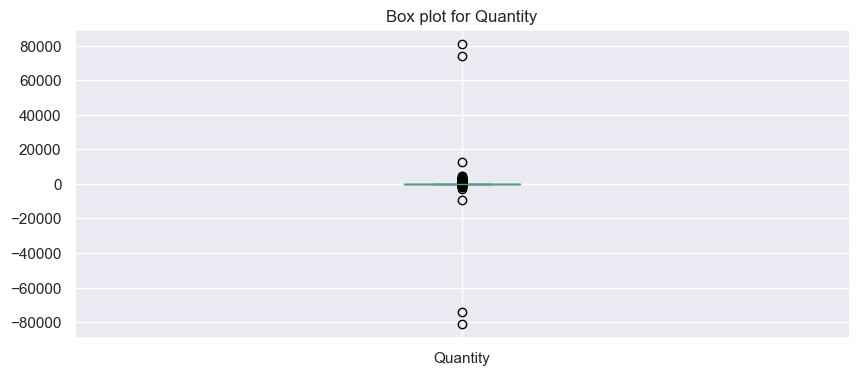

In [14]:
# Box plot for Quantity
plt.figure(figsize=(10,4))
plt.title("Box plot for Quantity")
data['Quantity'].plot(kind='box')
plt.show()

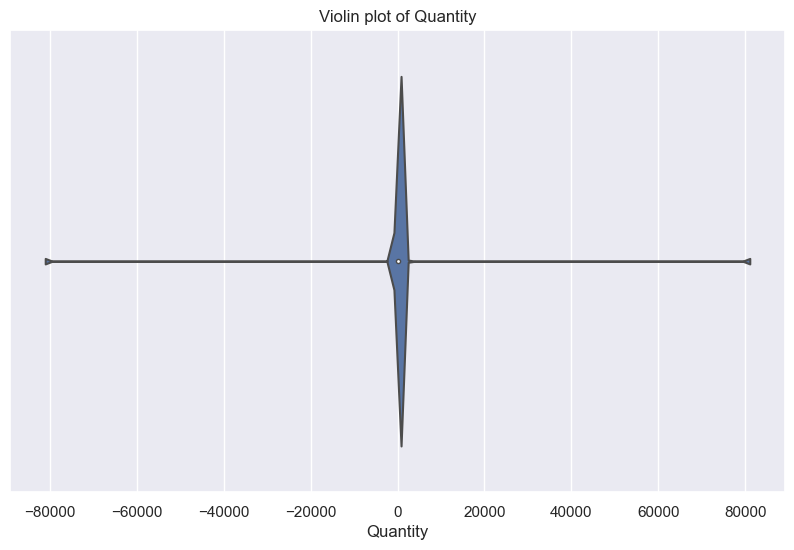

In [15]:
# Violin plot for Quantity
plt.figure(figsize=(10, 6))
sns.violinplot(x="Quantity", data=data)

plt.title('Violin plot of Quantity')
plt.show()

In [16]:
# Why are there negative quantities? That makes no sense. Let's remove them

data = data[data['Quantity'] > 0]

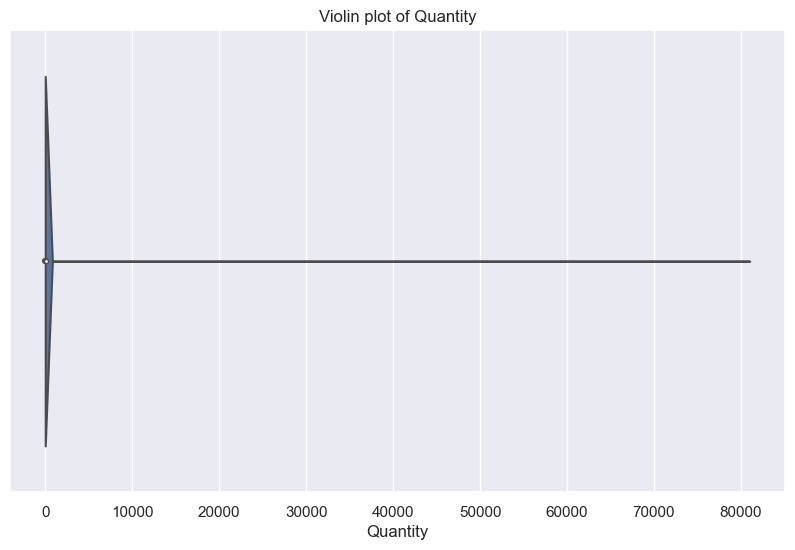

In [17]:
# Re-check Violin plot for Quantity
plt.figure(figsize=(10, 6))
sns.violinplot(x="Quantity", data=data)

plt.title('Violin plot of Quantity')
plt.show()

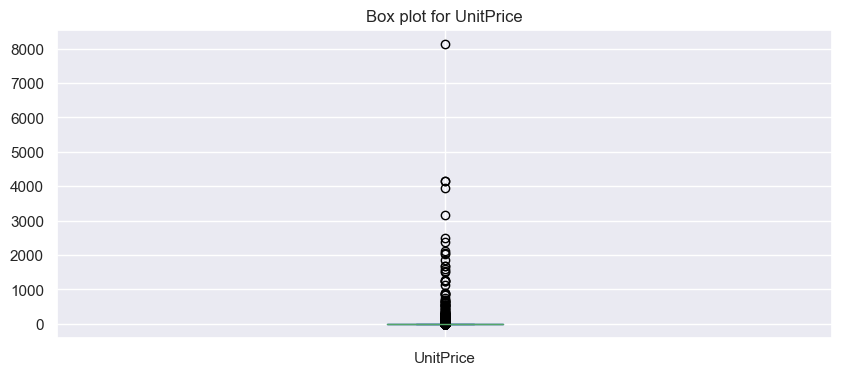

In [18]:
# Box plot for UnitPrice
plt.figure(figsize=(10,4))
plt.title("Box plot for UnitPrice")
data['UnitPrice'].plot(kind='box')
plt.show()

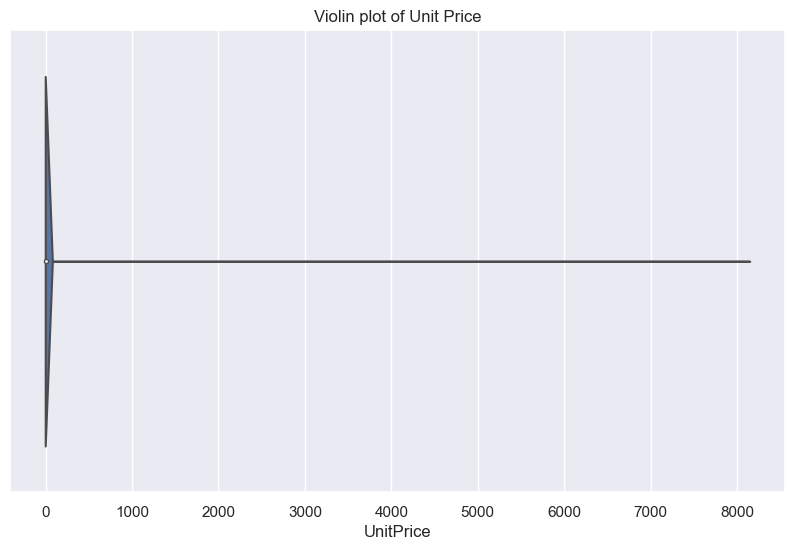

In [19]:
# Violin plot for UnitPrice
plt.figure(figsize=(10, 6))
sns.violinplot(x="UnitPrice", data=data)

plt.title('Violin plot of Unit Price')
plt.show()

## Check cardinality of categorical variables

In [20]:
data.nunique()

InvoiceNo      18536
StockCode       3665
Description     3877
Quantity         302
InvoiceDate    17286
UnitPrice        441
CustomerID      4339
Country           37
dtype: int64

In [21]:
# Convert the series into a DataFrame
df_nunique = data.nunique().reset_index()

# Rename the columns
df_nunique.columns = ['Column', 'Number of unique values']

# Sort the values in descending order
df_nunique = df_nunique.sort_values(by='Number of unique values', ascending=False)


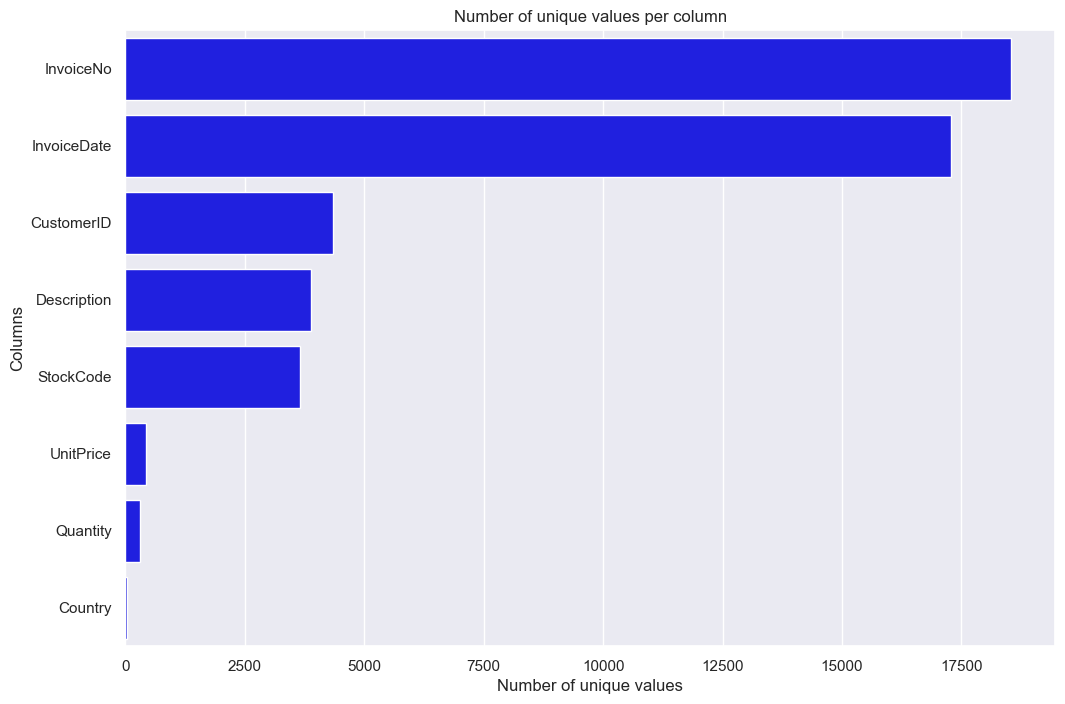

In [22]:
# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Number of unique values', y='Column', data=df_nunique, color='blue')

# Display the plot
plt.title('Number of unique values per column')
plt.xlabel('Number of unique values')
plt.ylabel('Columns')
plt.show()

## Handle categorical variables (convert incorrect dtypes, one-hot encoding, label encoding, etc. where necessary)

In [23]:
# There are 5 variables with object data types
# We will perform the following operations:
# InvoiceDate will be converted to date type
# CustomerID will be converted to object type/string
# Some variables that will not directly contribute to the model will be dropped
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392732 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    392732 non-null  object 
 1   StockCode    392732 non-null  object 
 2   Description  392732 non-null  object 
 3   Quantity     392732 non-null  int64  
 4   InvoiceDate  392732 non-null  object 
 5   UnitPrice    392732 non-null  float64
 6   CustomerID   392732 non-null  float64
 7   Country      392732 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.0+ MB


In [24]:
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
data["CustomerID"] = data["CustomerID"].astype(str)

## Normalize/standardize numerical variables

In [25]:
# CustomerID should actually be a string and not a float
# This leaves two numerical variables: Quantity and UnitPrice
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392732 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392732 non-null  object        
 1   StockCode    392732 non-null  object        
 2   Description  392732 non-null  object        
 3   Quantity     392732 non-null  int64         
 4   InvoiceDate  392732 non-null  datetime64[ns]
 5   UnitPrice    392732 non-null  float64       
 6   CustomerID   392732 non-null  object        
 7   Country      392732 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.0+ MB


## Conduct univariate analysis

In [26]:
data.describe(include='all').round(2).T

count unique                                 top    freq  \
InvoiceNo      392732  18536                              576339     542   
StockCode      392732   3665                              85123A    2023   
Description    392732   3877  WHITE HANGING HEART T-LIGHT HOLDER    2016   
Quantity     392732.0    NaN                                 NaN     NaN   
InvoiceDate    392732  17286                 2011-11-14 15:27:00     542   
UnitPrice    392732.0    NaN                                 NaN     NaN   
CustomerID     392732   4339                             17841.0    7676   
Country        392732     37                      United Kingdom  349227   

                          first                last   mean     std  min   25%  \
InvoiceNo                   NaT                 NaT    NaN     NaN  NaN   NaN   
StockCode                   NaT                 NaT    NaN     NaN  NaN   NaN   
Description                 NaT                 NaT    NaN     NaN  NaN   NaN   
Quantity                    NaT                 NaT  13.15  181.59  1.0   2.0   
InvoiceDate 2010-12-01 08:26:00 2011-12-09 12:50:00    NaN     NaN  NaN   NaN   
UnitPrice                   NaT                 NaT   3.13   22.24  0.0  1.25   
CustomerID                  NaT                 NaT    NaN     NaN  NaN   NaN   
Country                     NaT                 NaT    NaN     NaN  NaN   NaN   

              50%   75%      max  
InvoiceNo     NaN   NaN      NaN  
StockCode     NaN   NaN      NaN  
Description   NaN   NaN      NaN  
Quantity      6.0  12.0  80995.0  
InvoiceDate   NaN   NaN      NaN  
UnitPrice    1.95  3.75  8142.75  
CustomerID    NaN   NaN      NaN  
Country       NaN   NaN      NaN

In [27]:
profile = ProfileReport(data, title="Overview of Descriptive Statistics")

In [28]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Conduct bivariate analysis

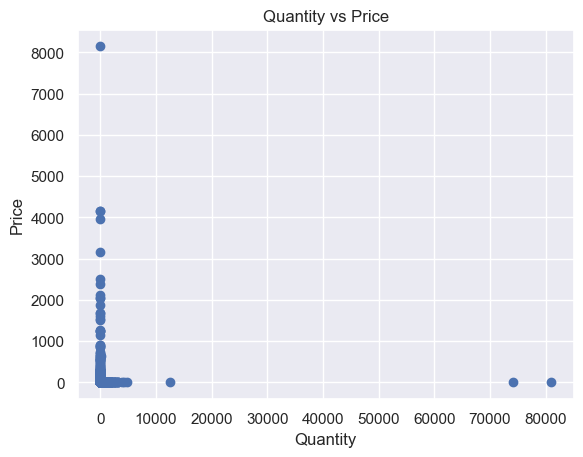

In [29]:
# Bivariate analysis of 'quantity' and 'price'
plt.scatter(data['Quantity'], data['UnitPrice'])
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.title('Quantity vs Price')
plt.show()

## Visualize distributions and correlations
- For distributions, we will use histograms
- For correlations, we will use heatmaps

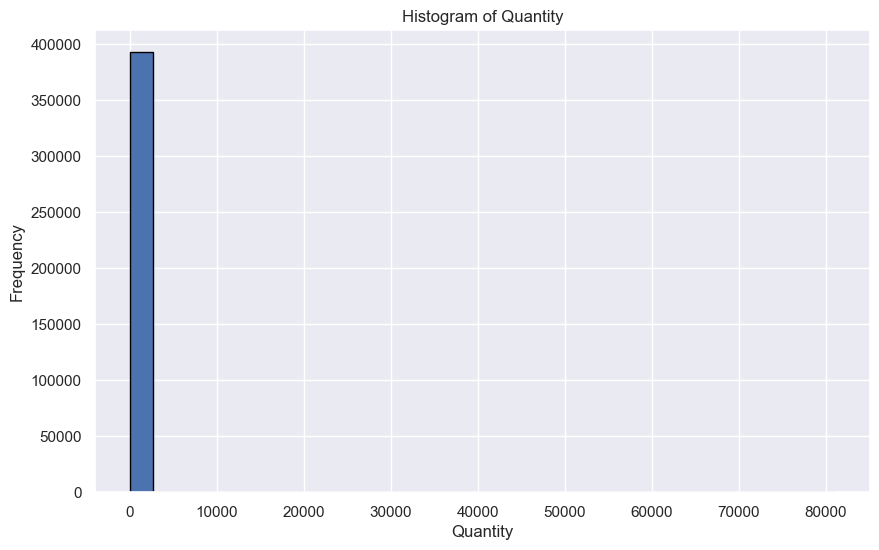

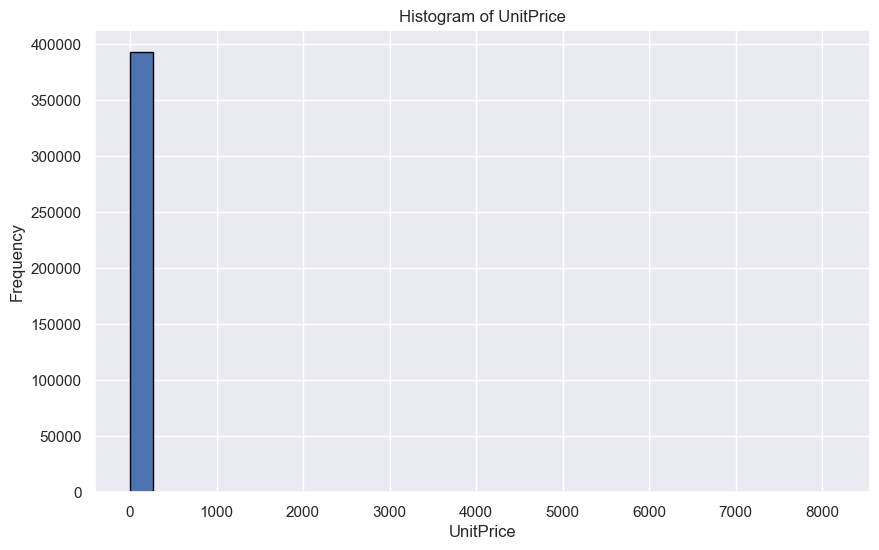

In [45]:
# Distributions
numeric_columns = ['Quantity', 'UnitPrice']

for col in numeric_columns:
    plt.figure(figsize=(10, 6))
    plt.hist(data[col], bins=30, edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

<Axes: >

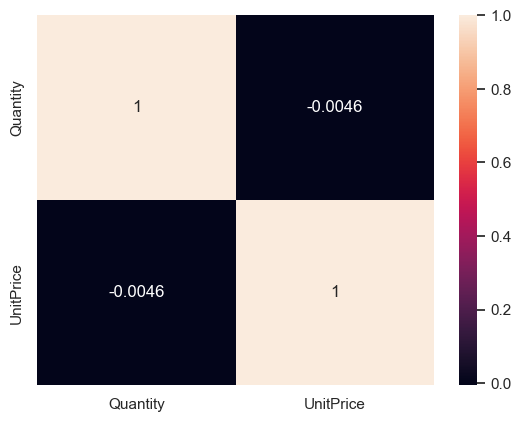

In [47]:
# Correlations
corr = data.corr()
sns.heatmap(corr, annot=True)

## Handling Outliers
UnitPrice and Quantity are highly skewed

In [49]:
from scipy.stats.mstats import winsorize
import numpy as np

# Winsorizing the 'UnitPrice' column
data['UnitPrice_Winsorized'] = winsorize(data['UnitPrice'], limits=[0.01, 0.01])

# Log transforming the 'Quantity' column
data['Quantity_Log'] = np.log(data['Quantity'])

# Removing outliers in 'UnitPrice'
Q1 = data['UnitPrice'].quantile(0.25)
Q3 = data['UnitPrice'].quantile(0.75)
IQR = Q3 - Q1
filter = (data['UnitPrice'] >= Q1 - 1.5 * IQR) & (data['UnitPrice'] <= Q3 + 1.5 *IQR)
data_no_outliers = data.loc[filter]  


In [51]:
data_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358620 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   InvoiceNo             358620 non-null  object        
 1   StockCode             358620 non-null  object        
 2   Description           358620 non-null  object        
 3   Quantity              358620 non-null  int64         
 4   InvoiceDate           358620 non-null  datetime64[ns]
 5   UnitPrice             358620 non-null  float64       
 6   CustomerID            358620 non-null  object        
 7   Country               358620 non-null  object        
 8   UnitPrice_Winsorized  358620 non-null  float64       
 9   Quantity_Log          358620 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 30.1+ MB


In [52]:
profile_no_outliers = ProfileReport(data_no_outliers, title="Overview of Descriptive Statistics (without Outliers in UnitPrice and Quantity)")

In [53]:
profile_no_outliers

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Model Training

# Model Evaluation

# Save Preprocessed Data